# Исследование алгоритмов кластеризации

In [24]:
pip freeze > "requirements (2).txt"

Note: you may need to restart the kernel to use updated packages.


# Импорт библиотек

In [2]:
import re
import string

import seaborn as sns
import spacy
import wget
from loguru import logger
import tqdm
import nltk
import numpy as np
import gensim,  logging
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 

# Функции предобработки текста

### Токенизация, лемматизация, приведение к нижнему регистру

In [3]:
def preprocess_text(
                    text, 
                    nlp,
                    punctuation, 
                    stop_words
                    ):
    doc = nlp(text.lower())  # Привести к нижнему регистру и лемматизировать
    lemmatized_words = [token.lemma_ + "_" + token.pos_ for token in doc if token.text not in punctuation and token.text not in stop_words 
                        and token.pos_ not in ["PUNCT", "SYM", "SPACE"] and len(token.text) > 2]
    return " ".join(lemmatized_words)

### Удаление стоп-слов, пунктуации, возвращает массив обработанных документов

In [4]:
def tokenize(
            documents: str
            ):
    nlp = spacy.load("ru_core_news_sm")
    nltk.download('stopwords')
    nltk.download('punkt')
    stop_words = set(stopwords.words('russian'))
    punctuation = set(string.punctuation)
    processed_text = []
    for text in documents:
        preprocessed_text = preprocess_text(text, nlp, punctuation, stop_words)
        # print("Оригинальный текст:", text)
        # print("Предобработанный текст:", preprocessed_text)
        # print("<----------------------------------------------->")
        processed_text.append(preprocessed_text)
    return processed_text 

# Методы векторизации текста

## Простые векторные представления

### TF-IDF векторизация документов

In [5]:
def tfidf_vectorizer(processed_text):
    tfidf = TfidfVectorizer(smooth_idf = True, norm = 'l2',  ngram_range = (2,2))  
    tfidf_matrix = tfidf.fit_transform(processed_text)
    important_words = tfidf.get_feature_names_out()
    # print("Метод векторизации TF-IDF:")
    # print("Важные слова:", important_words)
    return tfidf_matrix

### Векторизация методом BagOfWords

In [6]:
def count_vectorizer(processed_text):
    count_vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2,2))
    token_counter = count_vectorizer.fit_transform(processed_text)
    cv_features = count_vectorizer.get_feature_names_out()
    print("Метод векторизации BoW:")
    cv_dataframe = pd.DataFrame(token_counter.toarray(), columns = cv_features)
    return cv_dataframe

## Сложные векторные представления

### Word2Vec

#### Векторизация

In [7]:
def W2V_vectorizer(
                    dataframe, 
                    model
                    ):
    model_name = model
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    model = gensim.models.KeyedVectors.load_word2vec_format(model_name, binary = True)
    features = []
    for tokens in tokens_col:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    dataframe['vectors'] = features
    print("Метод векторизации Word2Vec")
    print("Количество векторов: ", len(features))
    print("Длина вектора: ", len(features))
    print
    return features

#### Обучениее модели

In [8]:
def W2V_training(dataframe):
    logger.debug("Токенизация....")
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    logger.success("Токенизация завершена успешно!")
    tokens_col = dataframe['tokens'].tolist()
    #1 - skipgram, 0 -cbow
    for algorithm in range(0,1):
        if algorithm == 0:
            logger.debug("Обучение методом CBOW")
            model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
            model.build_vocab(dataframe['tokens'])
            logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
            logger.debug("Обучение...")
            model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
            logger.success("Обучение завершено!")
            model_filename = f"w2v_cbow_{model.corpus_count}.bin"
            model.wv.save_word2vec_format(model_filename, binary=True)
            logger.success(f"Модель сохранена в {model_filename}")
            
        logger.debug("Обучение методом SkipGram")
        model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
        model.build_vocab(dataframe['tokens'])
        logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
        logger.debug("Обучение...")
        model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
        logger.success("Обучение завершено!")
        model_filename = f"w2v_skipgram_{model.corpus_count}.bin"
        model.wv.save_word2vec_format(model_filename, binary=True)
        logger.success(f"Модель сохранена в {model_filename}")

### FastText

In [9]:
def FastText_training(dataframe):
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    
    #    Параметры модели
    embedding_size = 100
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    
    ft_model = FastText(tokens_col,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=20)
    
    semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['я_NOUN', 'приехать_VERB', 'москва_PROPN', 'фотографировать_VERB', 'красиво_ADJ']}

    for k,v in semantically_similar_words.items():
        print(k+":"+str(v))

### Glove

# Методы кластеризации текста

## Вычисление оптимального количества кластеров. Метод локтя

In [10]:
def elbow_method(scaled_df):
    kmeans_kwargs = {
                    "init": "random",
                    "n_init": 10,
                    "random_state": 1,
                    }
    
    #create list to hold SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        kmeans.fit(scaled_df)
        sse.append(kmeans.inertia_)
    
    #visualize results
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Число кластеров")
    plt.ylabel("SSE")
    plt.show()

## K-Means

In [10]:
def kmeans_clusterization(
                            vectorized_text, 
                            n_clusters
                            ):
    #Инициализация метода главных компонент
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    clusters = kmeans.fit_predict(vectorized_text)
    print(f"For number of {n_clusters}:")
    print(f"Silhouette Coefficient: {metrics.silhouette_score(vectorized_text, clusters):.3f}")
    print(f"Inertia:{kmeans.inertia_}")


## MBK-Means

In [11]:
def mbkmeans_clusterization(
        X, 
        k, 
        mb, 
        print_silhouette_values, 
    ):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters = k, batch_size = mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key =lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

## DBScan

In [12]:
def dbscan_clusterization(
                            X, 
                            eps, 
                            min_samples
                            ):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

# Чтение датасета

In [21]:
news_df = pd.read_csv('reduced_news.csv', delimiter =',', low_memory = True)

In [22]:
news_df

,Unnamed: 0,url,title,text,topic,tags,date
0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...,...
423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [23]:
logger.success(f'Теги новостей: {news_df["tags"].unique()}, Количество: {len(news_df["tags"].unique())}')
logger.error(f'Темы новостей: {news_df["topic"].unique()}, Количество: {len(news_df["topic"].unique())}')

2024-03-14 20:26:48.182 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Общество' 'Политика' 'Культура' 'Интернет' 'Из жизни' 'Наука и техника'
 'Мир' 'Россия' 'Полиция и спецслужбы' 'Футбол' 'Белоруссия' 'Бокс и ММА'
 'ТВ и радио' 'Экономика' 'СВО/Украина' 'Следствие и суд' 'Среда обитания'
 'Явления' 'Забота о себе'], Количество: 19
2024-03-14 20:26:48.240 | ERROR    | __main__:<module>:2 - Темы новостей: ['Россия' 'Культура' 'Мир' 'Интернет и СМИ' 'Наука и техника'
 'Путешествия' 'Силовые структуры' 'Спорт' 'Из жизни' 'Бывший СССР'
 'Экономика' 'Нацпроекты' 'Среда обитания' 'Дом' 'Ценности'
 '69-я параллель' 'Бизнес' 'Моя страна' 'Забота о себе'], Количество: 19


In [11]:
actual_news_df = pd.read_csv('lenta_ru_news_2019_2023.csv', delimiter =',', low_memory = True)

In [12]:
actual_news_df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Фотография,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,Украина,2024-01-01


In [13]:
actual_news_df = actual_news_df.dropna()

In [14]:
actual_news_df["tags"] = actual_news_df["tags"].replace("Украина", "СВО/Украина")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги', 'Сериалы'], "Культура")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Социальная сфера', 'Госэкономика', 'Деловой климат',
       'Бизнес', 'Рынки', 'Капитал', 'Инвестиции'], "Экономика")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Звери', 'Происшествия', 'Люди', 'Еда', 'Персоны',
       'Счастливчики', 'Аномалии'], "Из жизни")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Наука', 'Гаджеты', 'Оружие', 'Космос', 'История', 'Здоровье',
       'Техника', 'Игры', 'Софт', 'Будущее', 'В России'], "Наука и техника")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Город', 'Дом', 'Климат и экология', 'Край', 'Транспорт'], "Среда обитания")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Уход за собой', 'Питание и сон', 'Ментальное здоровье',
       'Окружающее пространство', 'Отношения'], "Забота о себе")
actual_news_df

C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df["tags"] = actual_news_df["tags"].replace("Украина", "СВО/Украина")
C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df["tags"] = actual_news_df["tags"].replace(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги', 'Сериалы'], "Культура")
C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [24]:
actual_news_df[actual_news_df["topic"] == "Культура"]["tags"].unique()


array(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги',
       'Все', 'Сериалы'], dtype=object)

In [25]:
actual_news_df[actual_news_df["topic"] == "Экономика"]["tags"].unique()

array(['Социальная сфера', 'Госэкономика', 'Все', 'Деловой климат',
       'Бизнес', 'Рынки', 'Капитал', 'Инвестиции'], dtype=object)

In [26]:
actual_news_df[actual_news_df["topic"] == "Из жизни"]["tags"].unique()

array(['Звери', 'Происшествия', 'Люди', 'Еда', 'Все', 'Персоны',
       'Счастливчики', 'Аномалии'], dtype=object)

In [28]:
actual_news_df[actual_news_df["topic"] == "Наука и техника"]["tags"].unique()

array(['Наука', 'Гаджеты', 'Оружие', 'Космос', 'История', 'Здоровье',
       'Техника', 'Игры', 'Все', 'Софт', 'Будущее', 'В России'],
      dtype=object)

In [30]:
actual_news_df[actual_news_df["topic"] == "Среда обитания"]["tags"].unique()

array(['Город', 'Дом', 'Все', 'Климат и экология', 'Край', 'Транспорт'],
      dtype=object)

In [33]:
actual_news_df[actual_news_df["topic"] == "Забота о себе"]["tags"].unique()

array(['Уход за собой', 'Питание и сон', 'Ментальное здоровье',
       'Окружающее пространство', 'Отношения', 'Все'], dtype=object)

In [15]:
category_counts = actual_news_df['tags'].value_counts()

min_count = 5000
# Отфильтровываем строки, где количество категорий больше или равно min_count
actual_news_df = actual_news_df[actual_news_df['tags'].isin(category_counts[category_counts > min_count].index)]

actual_news_df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [94]:
actual_news_df.drop(actual_news_df.loc[actual_news_df["tags"] == ""].index, inplace=True)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [20]:
actual_news_df.to_csv('reduced_news.csv', encoding='utf-8')

In [16]:
logger.success(f'Теги новостей: {actual_news_df["tags"].unique()}, Количество: {len(actual_news_df["tags"].unique())}')
logger.error(f'Темы новостей: {actual_news_df["topic"].unique()}, Количество: {len(actual_news_df["topic"].unique())}')

2024-03-14 20:19:57.581 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Общество' 'Политика' 'Культура' 'Интернет' 'Из жизни' 'Наука и техника'
 'Мир' 'Россия' 'Полиция и спецслужбы' 'Футбол' 'Белоруссия' 'Бокс и ММА'
 'ТВ и радио' 'Экономика' 'СВО/Украина' 'Следствие и суд' 'Среда обитания'
 'Явления' 'Забота о себе'], Количество: 19
2024-03-14 20:19:57.656 | ERROR    | __main__:<module>:2 - Темы новостей: ['Россия' 'Культура' 'Мир' 'Интернет и СМИ' 'Наука и техника'
 'Путешествия' 'Силовые структуры' 'Спорт' 'Из жизни' 'Бывший СССР'
 'Экономика' 'Нацпроекты' 'Среда обитания' 'Дом' 'Ценности'
 '69-я параллель' 'Бизнес' 'Моя страна' 'Забота о себе'], Количество: 19


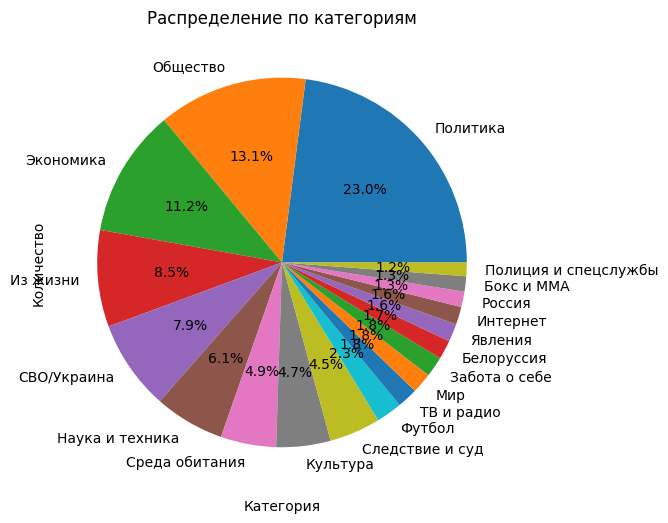

In [17]:
category_counts = actual_news_df['tags'].value_counts()

# Создание графика
plt.figure(figsize=(10, 6))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

C:\Users\Doskin\AppData\Local\Temp\ipykernel_1896\1758919247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])


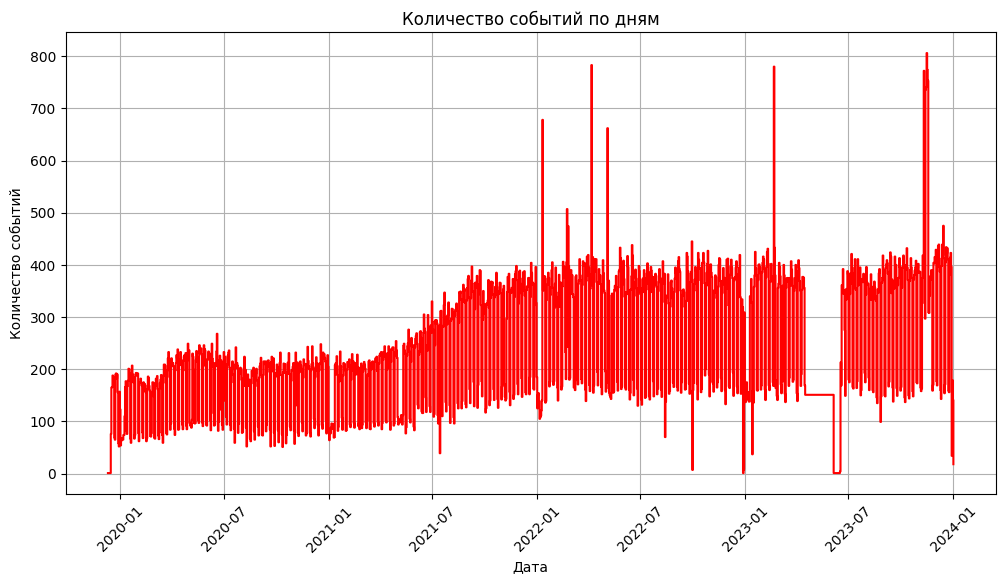

In [40]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Группировка данных по дате и подсчет количества событий в день
events_per_day = actual_news_df.groupby('date').size()

# Создание графика
plt.figure(figsize=(12, 6))
plt.plot(events_per_day.index, events_per_day.values, color='red',  drawstyle='steps-post')
plt.title('Количество событий по дням')

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, max(events_per_day.values), 100))
plt.show()

C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\10219950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])


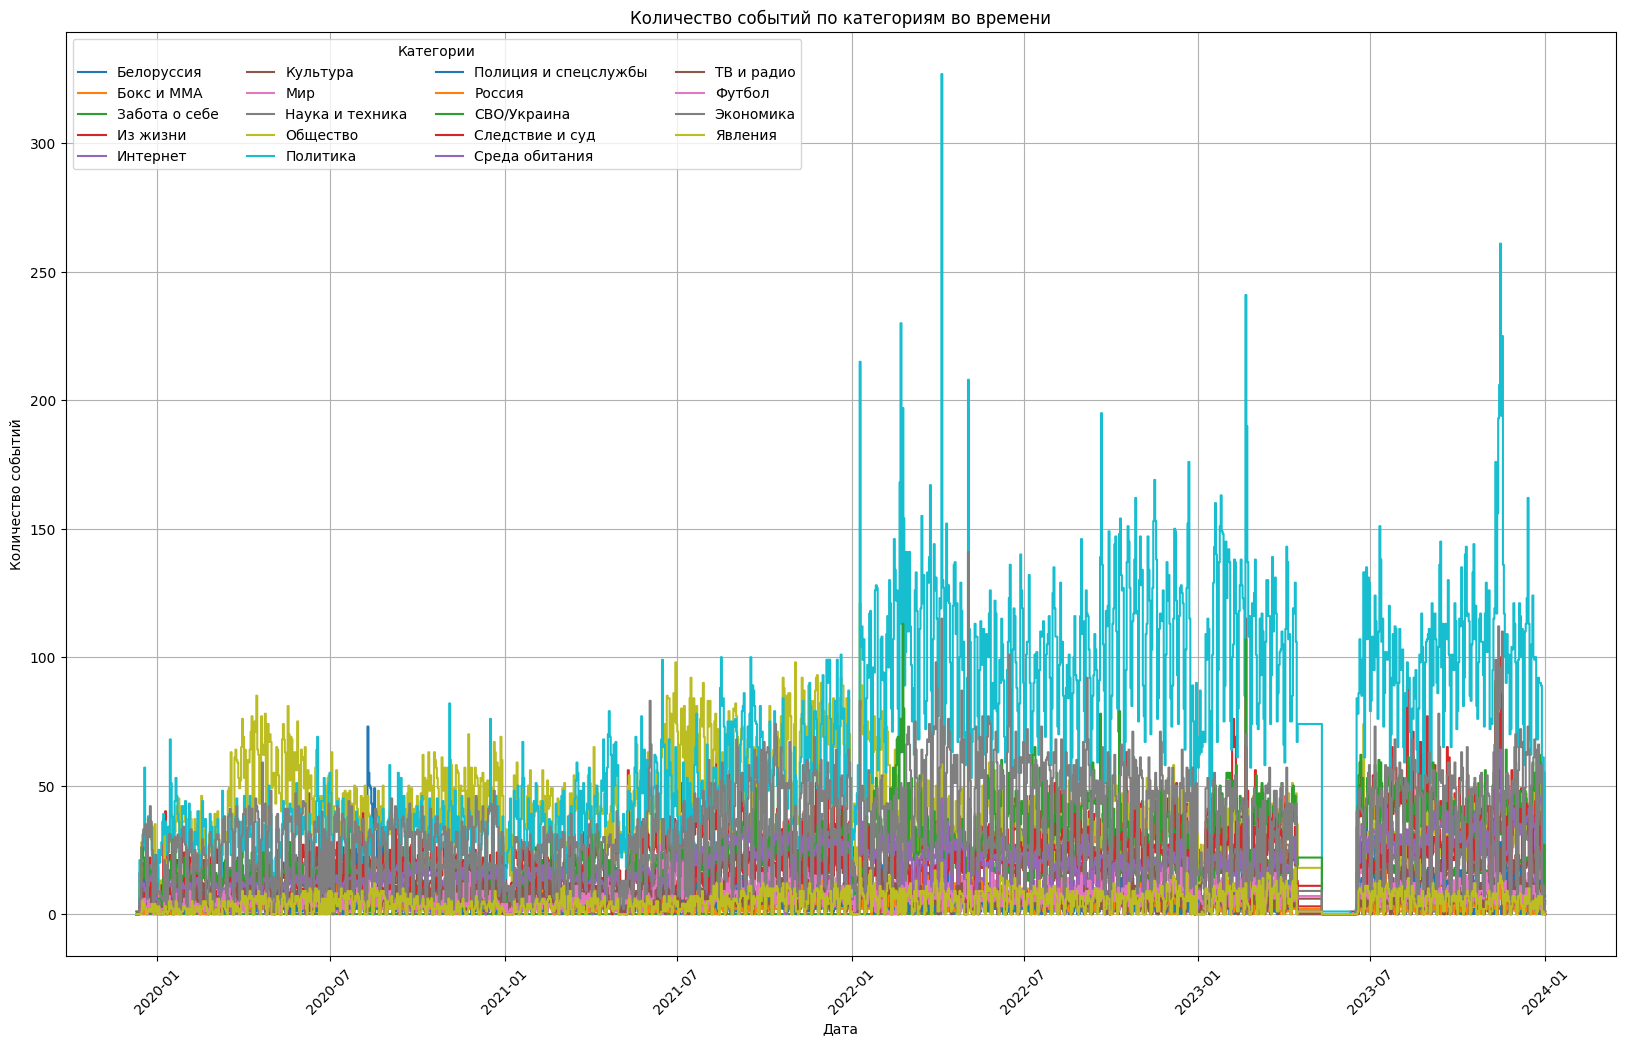

In [19]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Создание сводной таблицы с количеством событий по датам и категориям
pivot_table = actual_news_df.pivot_table(index='date', columns='tags', aggfunc='size', fill_value=0)
pivot_table
# Построение линейного графика
plt.figure(figsize=(20, 12))
for column in pivot_table.columns:
    col = (np.random.random (), np.random.random (), np.random.random ())
    plt.plot(pivot_table.index, pivot_table[column], label=column,  drawstyle='steps-mid')

plt.title('Количество событий по категориям во времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(loc='upper left', ncols=4, title="Категории")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [92]:
cut_df = news_df[['text', 'topic']].head(1500)
cut_df
logger.debug(f'Теги новостей: {cut_df["topic"].unique()}, Количество: {len(cut_df["topic"].unique())}')

2024-03-12 22:35:26.386 | DEBUG    | __main__:<module>:3 - Теги новостей: ['Библиотека' 'Россия' 'Мир' 'Экономика' 'Интернет и СМИ'], Количество: 5


## TF-IDF векторизация

In [ ]:
X_tfidf = tfidf_vectorizer(tokenize(cut_df['text']))

### K-means

In [ ]:
kmeans_clusterization(vectorized_text = X_tfidf,
                      n_clusters=4
                     )

### MiniBatchKMeans

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=X_tfidf,
    k=2,
    mb=500,
    print_silhouette_values=True,
)

### DBSCAN

In [ ]:
dbscan_clusterization(X=X_tfidf,
                      eps=1,
                      min_samples= 3  
                     )

In [ ]:
%%time
FastText_training(cut_df)

## Word2Vec векторизацияя

In [ ]:
%%time
W2V_training(cut_df)

### SkipGram

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
skipgram_vectorized_docs = W2V_vectorizer(cut_df, "w2v_skipgram_1500.bin")

In [ ]:
dbscan_clusterization(X=skipgram_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )

In [ ]:
elbow_method(vectorized_docs)

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=skipgram_vectorized_docs,
    k=4,
    mb=400,
    print_silhouette_values=True,
)

### CBOW

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cbow_vectorized_docs = W2V_vectorizer(cut_df, "w2v_cbow_1500.bin")

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=cbow_vectorized_docs,
    k=4,
    mb=500,
    print_silhouette_values=True
)

In [ ]:
dbscan_clusterization(X=cbow_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )